In [1]:
import importlib

from keras.layers import Input, Embedding, GRU, Bidirectional, Dense, Lambda
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import plot_model

import numpy as np
import random
import pickle as pkl

from qgen.data import training_data, test_data, collapse_documents, expand_answers, _read_data

import qgen.utils as utils
from qgen.embedding import glove

import matplotlib.pyplot as plt

/Users/davidfoster/.virtualenvs/gdl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


KeyboardInterrupt: 

In [ ]:
#### PARAMETERS ####

VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

print('GLOVE')
print('VOCAB_SIZE: ', VOCAB_SIZE)
print('EMBEDDING_DIMENS: ', EMBEDDING_DIMENS)

GRU_UNITS = 100
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None


In [ ]:
#### TRAINING MODEL ####

document_tokens = Input(shape=(MAX_DOC_SIZE,), name="document_tokens")

embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIMENS, weights=[glove], mask_zero = True, name = 'embedding')
document_emb = embedding(document_tokens)

answer_outputs = Bidirectional(GRU(GRU_UNITS, return_sequences=True), name = 'answer_outputs')(document_emb)
answer_tags = Dense(2, activation = 'softmax', name = 'answer_tags')(answer_outputs)

encoder_input_mask = Input(shape=(MAX_ANSWER_SIZE, MAX_DOC_SIZE), name="encoder_input_mask")
encoder_inputs = Lambda(lambda x: K.batch_dot(x[0], x[1]), name="encoder_inputs")([encoder_input_mask, answer_outputs])
encoder_cell = GRU(2 * GRU_UNITS, name = 'encoder_cell')(encoder_inputs)

decoder_inputs = Input(shape=(MAX_Q_SIZE,), name="decoder_inputs")
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False
decoder_cell = GRU(2 * GRU_UNITS, return_sequences = True, name = 'decoder_cell')
decoder_states = decoder_cell(decoder_emb, initial_state = [encoder_cell])

decoder_projection = Dense(VOCAB_SIZE, name = 'decoder_projection', activation = 'softmax', use_bias = False)
decoder_outputs = decoder_projection(decoder_states)

total_model = Model([document_tokens, decoder_inputs, encoder_input_mask], [answer_tags, decoder_outputs])
plot_model(total_model, to_file='model.png',show_shapes=True)

In [ ]:
answer_model = Model(document_tokens, [answer_tags])
decoder_initial_state_model = Model([document_tokens, encoder_input_mask], [encoder_cell])

In [ ]:
total_model.summary()

In [ ]:
#### INFERENCE MODEL ####

decoder_inputs_dynamic = Input(shape=(1,), name="decoder_inputs_dynamic")
decoder_emb_dynamic = embedding(decoder_inputs_dynamic)
decoder_init_state_dynamic = Input(shape=(2 * GRU_UNITS,), name = 'decoder_init_state_dynamic') #the embedding of the previous word
decoder_states_dynamic = decoder_cell(decoder_emb_dynamic, initial_state = [decoder_init_state_dynamic])
decoder_outputs_dynamic = decoder_projection(decoder_states_dynamic)

question_model = Model([decoder_inputs_dynamic, decoder_init_state_dynamic], [decoder_outputs_dynamic, decoder_states_dynamic])



In [ ]:
#### COMPILE TRAINING MODEL ####

opti = Adam(lr=0.001)
total_model.compile(loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy']
                    , optimizer=opti
                    , loss_weights = [1,1]) 


In [ ]:
#### LOAD DATA ####

training_data_gen = training_data()
# training_data_gen = [next(training_data_gen)]
test_data_gen = test_data()

training_loss_history = []
test_loss_history = []


In [ ]:
t = next(training_data_gen)

In [ ]:
idx = 0

print('document_tokens\n', t['document_tokens'][idx])
print('\n')
print('question_input_tokens\n', t['question_input_tokens'][idx])
print('\n')
print('answer_masks\n', t['answer_masks'][idx])
print('\n')
print('answer_labels\n', t['answer_labels'][idx])
print('\n')
print('question_output_tokens\n', t['question_output_tokens'][idx])

In [ ]:
#### TRAIN MODEL ####

EPOCHS = 2000

start_epoch = 1

for epoch in range(start_epoch, start_epoch + EPOCHS + 1):
    print("Epoch {0}".format(epoch))
    
    for i, batch in enumerate(training_data()):
        
        val_batch = next(test_data_gen, None)
        
        if val_batch is None:
            test_data_gen = test_data()
            val_batch = next(test_data_gen, None)
            
        training_loss = total_model.train_on_batch(
            [batch['document_tokens'], batch['question_input_tokens'], batch['answer_masks']]
            , [np.expand_dims(batch['answer_labels'], axis = -1), np.expand_dims(batch['question_output_tokens'], axis = -1)]
        )
        
        test_loss = total_model.test_on_batch(
            [val_batch['document_tokens'], val_batch['question_input_tokens'], val_batch['answer_masks']]
            , [np.expand_dims(val_batch['answer_labels'], axis = -1), np.expand_dims(val_batch['question_output_tokens'], axis = -1)]
        )
        
        training_loss_history.append(training_loss)
        test_loss_history.append(test_loss)
        
        print("{}: Train Loss: {} | Test Loss: {}".format(i, training_loss, test_loss))
        
    total_model.save_weights('./saved_models/keras_{}.h5'.format(epoch))
        

In [ ]:
#### LOAD OLD MODELS ####

# total_model.load_weights('./saved_models/keras_1.h5', by_name = True)
# question_model.load_weights('./saved_models/keras_1.h5', by_name = True)
# answer_model.load_weights('./saved_models/keras_1.h5', by_name = True)
# decoder_initial_state_model.load_weights('./saved_models/keras_1.h5', by_name = True)

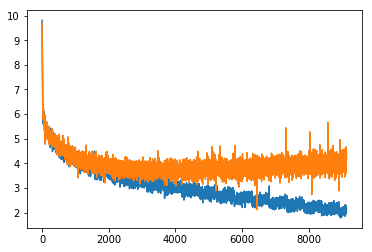

In [9]:
#### SHOW LOSSES ####

utils.show_losses(np.array(training_loss_history)[:,0], np.array(test_loss_history)[:,0])
pkl.dump([training_loss_history, test_loss_history], open('./saved_models/histories.pkl', 'wb'))

In [10]:
#### GET TEST BATCH

batch = next(test_data_gen)
batch = collapse_documents(batch)

In [10]:
#### TESTING ####

importlib.reload(utils)

idx = 0
idx = random.randint(0,10)
print(idx)

answer_preds = answer_model.predict(batch["document_tokens"])

answers = np.squeeze(np.round(answer_preds))
answer_batch = expand_answers(batch, answers)

utils.show_test(batch, answer_batch, idx, answer_model, decoder_initial_state_model, question_model)

#### PLOT ANSWER LIKELIHOOD ####
plt.plot(batch['answer_labels'][idx])
plt.plot(answer_preds[idx])
plt.show()

0

 TEXT
NEW YORK -LRB- CNN -RRB- -- Yet another scale Il Divo has mastered : scaling the heights of success . The quartet was formed in 2004 after a global search . The operatic quartet 's new album , `` The Promise , '' debuted atop the UK charts , their third collection to hit the No. 1 spot . The album -LRB- which was released in the U.S. last Tuesday -RRB- features Leonard Cohen 's `` Hallelujah , '' Frankie Goes to Hollywood 's `` The Power of Love , '' and the traditional `` Amazing Grace . '' Il Divo also takes a chance on the ABBA hit `` The Winner Takes it All . '' The group is the brainchild of `` American Idol '' judge Simon Cowell , who saw a potential market for an international , `` popera '' - style act after the soaring success of the Andrea Bocelli-Sarah Brightman duet `` Time to Say Goodbye -LRB- Con te Partiro -RRB- . '' Watch Il Divo in action '' Formed in 2004 after a global search , Il Divo -LRB- Italian for `` divine male performer '' -RRB- consists of Spanish b

InvalidArgumentError: Tried to read from index -1 but array size is: 0
	 [[{{node encoder_cell/TensorArrayReadV3}} = TensorArrayReadV3[_class=["loc:@train...rayWriteV3"], dtype=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](encoder_cell/TensorArray, encoder_cell/sub_1, encoder_cell/while/Exit_1)]]